# ALGORYTM EWOLUCYJNY - GRAFY

Grafy są strukturami matematycznymi używanymi do modelowania relacji między parami obiektów. Składają się z wierzchołków (zwanych również węzłami lub punktami), które są połączone krawędziami (zwanymi również łączami lub liniami), które wyznaczją sposób poruszania np. z wierzchołka 0 można przejść do wierzchołka 1.

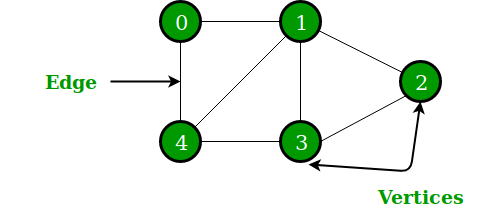

Zadany problem dotyczy rysowania grafów, w taki sposób, by wyznaczony model zawierał możliwie minimalną liczbę skrzyżowań między krawędziami. Dodatkowo przyjęto, by krawędzie były rysowane jako odcinki linii prostej, a nie dowolne krzywe. Naszym zadaniem jest znalezienie takich współrzędnych wierzchołków, aby były spełnione powyższe założenia. 

#IMPORTOWANIE BIBLIOTEK
Tutaj importujemy wszystkie biblioteki, z których będziemy potrzebować dostępu do funkcji.

In [ ]:
!pip install pygad

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 KB 3.0 MB/s eta 0:00:00


In [ ]:
import pygad 
import matplotlib.pyplot as plt
import numpy as np

#WCZYTYWANIE DANYCH

Potrzebne dane dla algorytmu genetycznego, tj. relacje w grafie, zadane są w postaci pliku tekstowego: 
N 
x1 x2 ... 
gdzie N oznacza liczbę wierzchołków, a xN oznaczają krawędzie. 
Przykładowo:
> 4

> 1 3 1 4 2 3 2 4 

Opisuje graf o 4 wierzchołkach i 4 krawędziach łączących wierzchołki 1 z 3, 1 z 4, 2 z 3 oraz 2 z 4.

Funkcja read_graph przyjmuje jako argument nazwę pliku tekstowego, a następnie wczytuje go towrząc z kolejnych numerów wierzchołków listę, a następnie krotki. Każda krotka reprezentuje jedną krawędź wyznaczoną między parą wierzchołków, czyli relacje między nimi. Funkcja zwraca liczbę wierzchołków, krawędzi oraz krawędzie reprezentowane w postaci krotek.

In [ ]:
def read_graph(filename):
  # Wczytywanie danych z pliku tekstowego
  data = np.loadtxt(filename, delimiter=',', skiprows=0, dtype=str)

  vert_number = int(data.tolist()[0]) 
  edges_list = data.tolist()[1].split(" ") # ['1', '8', '1', '9', '1', '10', '1', '11']
  edges_list = [int(i) for i in edges_list] # -> int

  # tworzenie krotek zawierających krawędzie
  edges = []
  step = 2
  for i in range(0, len(edges_list), step):
    tmp_li = edges_list[i:i+step]
    edges.append(tuple(tmp_li))

  print("Edges: ", edges)
  print("Number of vertices: ", vert_number)
  edges_number = len(edges)
  return vert_number, edges,edges_number

vert_num, edges, edges_num = read_graph('data2.txt')

Edges:  [(1, 8), (1, 9), (1, 10), (1, 11), (2, 8), (2, 9), (2, 10), (2, 11), (3, 8), (3, 9), (3, 10), (3, 11), (4, 8), (4, 9), (4, 10), (4, 11), (5, 8), (5, 9), (5, 10), (5, 11), (6, 8), (6, 9), (6, 10), (6, 11), (7, 8), (7, 9), (7, 10), (7, 11)]
Number of vertices:  11


#SPRAWDZANIE KRAWĘDZI PRZECINAJĄCYCH SIĘ

Do poszukiwania przecinających się krawędzi w grafie użyto funkcji intersects zwracającej True/False jeśli krawędzie przecinają się bądź nie.
Funkcja intersects() dopuszcza jednak sytuacje, w której wierzchołki krawędzi nakładają się i tworzą krawędzie przecinające się (dwie krawędzie rozpoczynają się w tym samym wierzchołku). By wykluczyć taki przypadek dodano odpowiednie instrukcje warunkowe.

In [ ]:
from shapely.geometry import LineString

def is_intersecting(segment0,segment1):

  # jeśli współrzędne końców odcinków się pokrywają, nie chcemy zwracac prawdy, np:
  # segment0 - AB
  # segment1- AC

  if segment0[0] == segment1[0] or segment0[0] == segment1[1]:
    return False
  if segment0[1] == segment1[0] or segment0[1] == segment1[1]:
    return False

  line = LineString(segment0)
  other = LineString(segment1)
  return(line.intersects(other))

##POMOCNICZE FUNKCJE

Funkcja bin_to_dec służy do wyodrębnienia współrzędnych z chromosomów w postaci binarnej.
Każdy z chromosomów odpowiada współrzędnym wszystkich wierzchołków w grafie.

In [ ]:
def list_to_string(li):
    for i in range(len(li)):
      li[i] = int(li[i])
    return ''.join(str(elem) for elem in li)

def bin_to_dec(data):
  data = list(data)

  #dzielimy chromosom co 20 bitów - pierwsze 10 to współrzędna x, kolejne 10 to y 
  coordinates = []
  for l in range(0,len(data),20):
    temp_list_x = data[l:l+10]
    temp_list_y= data[l+10:l+20]

    x = list_to_string(temp_list_x)
    y = list_to_string(temp_list_y)

    x = int(x,2)/1000
    y = int(y,2)/1000

    coordinates.append((x,y)) #zapisujemy współrzędne wierzchołka jako krotka

  return coordinates #zwracamy współrzędne wierzchołków


Funkcja get_coordinates służy zamianie pary wierzchołków (połączonych krawędzią) i zwróceniu odpowiadającym im współrzędnym.

In [ ]:
def get_coordinates(edge, data):
  # wyznaczamy współrzędne końcow odcinka (krawedzi)

  # edges -> [(1, 3), (1, 4), (2, 3), (2, 4)]
  # edge -> (1,3)
  # data -> [(0.938, 0.106), (0.776, 1.002), (0.245, 0.429), (0.28, 0.719)]
  
  vert1 = data[edge[0]-1]
  vert2 = data[edge[1]-1]
  return [vert1, vert2]

  # [(x1,y1), (x2,y2)] #format dla funkcji intersects

#IMPLEMENTACJA FUNKCJI FITNESS

Wybrana biblioteka pygad pozwala na optymalizację różnych typów problemów za pomocą algorytmu genetycznego poprzez dostosowanie funkcji fitness.
Dla postawionego zadania funkcja fitness zlicza liczbę przecinających się krawędzi w grafie i wybiera najlepszego osobnika, dla którego ta liczba jest najmniejsza. Najlepsza wartość fitness jest równa 0 i odpowiada grafowi o nieprzecinających się krawędziach. Dlatego przyjęto, że liczba zwracanych przecięć krawędzi w grafie jest wartością ujemną.

In [ ]:


def fitness_func(solution, solution_idx):
  #zamysł -> sprawdzamy ile razy przecinają sie krawędzie w grafie

  data = bin_to_dec(solution)
  intersections_counter = 0 #fitness 

  # przeszukujemy wszystkie istniejace krawedzie i sprawdzamy czy się przecinają
  for i in range(edges_num):
    for j in range(i+1, edges_num):
      edge1_coords = get_coordinates(edges[i], data)
      edge2_coords = get_coordinates(edges[j], data)

      if is_intersecting(edge1_coords,edge2_coords):
        intersections_counter += 1
    
  return -(intersections_counter) # nasza wartość fitness to ujemna ilość przecięć krawędzi


#ALGORYTM GENETYCZNY - MODEL PODSTAWOWY

Po przygotowaniu funkcji fitness tworzona jest instancja klasy pygad.GA wraz z parametrami dotyczącymi ewolucji populacji (liczba generacji, liczba rozwiązań - rodziców, liczba rozwiązań w obrębie populacji, liczba genów w chormosomie - liczba wierzchołków * 10(precyzja) * 2(para wierzchołków), typ selekcji (sss-statyczna), prawdopodobieństwo wyboru rodzica do zastosowania operacji crossover, typ operacji krzyżowania (single_point-jednopunktowe), prawdopodobieństwo wyboru genu do zastosowania operacji mutacji, typ mutacji (random), liczba rodziców do utrzymania w obecnej populacji, procent genów ulegających mutacji, możliwe wartości dla każdego genu, zaimplementowana funkcja fitness.
Po utworzeniu instancji wywoływana jest metoda run() w celu rozpoczęcia optymalizacji. Po zakończeniu działania metody run() można uzyskać dostęp do informacji o najlepszym rozwiązaniu znalezionym przez PyGAD - solution_fitness.

In [ ]:


# num_genes = vert_num*10*2:
# chromosom: x,y x,y x,y <- współrzędne wierzchołków
#            1   2   3 <- wierzcholki
# ilość wierzchołków * 10 (ilosc bitow na kt kodujemy liczbe) * 2 (po 2 współrzedne na wierzcholek) 

fitness_function = fitness_func
ga_instance = pygad.GA(num_generations = 500,
                       num_parents_mating = 2,
                       sol_per_pop = 20, # ilość osobników
                       num_genes = vert_num*10*2,
                       parent_selection_type = "sss", #steady-state selection
                       crossover_probability = 0.6,
                       crossover_type = "single_point",
                       mutation_probability = 0.2,
                       mutation_type = "random",
                       keep_parents = 1,
                       mutation_percent_genes = 10,
                       fitness_func=fitness_function,
                       gene_space=[0, 1])



##PROBLEM CEGIELNI TURANA

Pál Turán został zmuszony do pracy w cegielni. Jego zadaniem było pchanie wagonów z cegłami po torach z pieca do magazynu. W fabryce znajdowało się kilka pieców i magazynów, a między nimi biegły tory, które przecinały podłogę. Turán zauważył, że trudno jest przepchnąć wagonik przez skrzyżowanie torów i zaczął się zastanawiać, jak można by przeprojektować fabrykę, by zminimalizować te skrzyżowania.
Z matematycznego punktu widzenia problem ten można sformułować jako próbe narysowania grafu pełnego dwudzielnego, którego wierzchołki reprezentują piece i miejsca składowania, a krawędzie reprezentują ścieżki od każdego pieca do każdego miejsca składowania. 
Kazimierz Zarankiewicz i Kazimierz Urbanik wykazali, że zawsze można ułożyć układ jak na rysunku poniżej, z piecami wzdłuż jednej osi i składami wzdłuż drugiej, każdą grupą rozmieszczoną możliwie równo wokół początku, z torami biegnącymi jako linie proste między każdą możliwą parą.

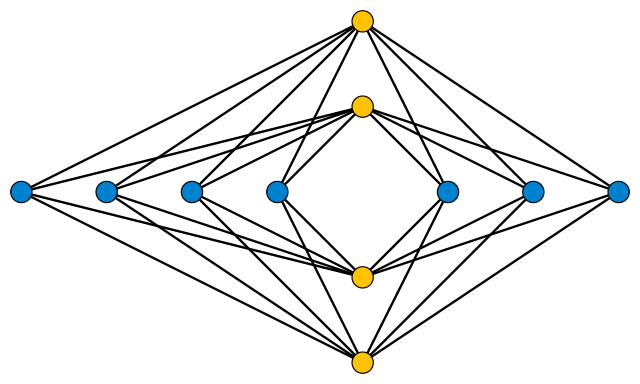

Dla 4 pieców (żółte wierzchołki) i 7 składowisk (niebieskie wierzchołki) rozwiązanie Zarankiewicza przewiduje 18 przecinających się krawędzi grafu i jest uznawane jako optymalne.

Wykorzystując ten sam graf i jego relacje między wierzchołkami uruchomiono model podstawowy alogyrtmu genetycznego osiągając następujące rezulaty:

In [ ]:
ga_instance.run()
solution, solution_fitness, solution_idx = ga_instance.best_solution()

print("Solution fitness: ", solution_fitness)


Solution fitness:  -20


##WIZUALIZACJA WYNIKÓW

Poniżej znajduje się rysunek grafu, który jest najlepszym osobnikiem otrzymanym podczas całej ewolucji.

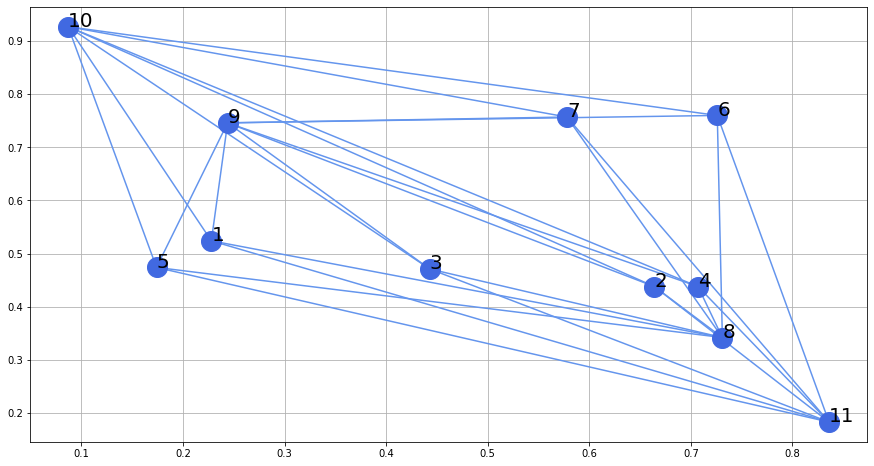

In [ ]:
def plot_graph(solution_gen,edges_num_gen,edges_gen,vert_num_gen):
  plt.figure(figsize=(15,8))
  vertices_coords = bin_to_dec(solution_gen)


  #rysowanie krawędzi
  for j in range(edges_num_gen):
    segment_start_num = edges_gen[j][0]
    segment_end_num = edges_gen[j][1]

    segment_start_coords = list(vertices_coords[segment_start_num-1])
    segment_end_coords = list(vertices_coords[segment_end_num-1])

    x_values = [segment_start_coords[0], segment_end_coords[0]]
    y_values = [segment_start_coords[1], segment_end_coords[1]]
    
    plt.plot(x_values, y_values, color="cornflowerblue")
    
  #rysowanie wierzchołków grafu
  for i in range(vert_num):
    x=vertices_coords[i][0]
    y=vertices_coords[i][1]
    plt.plot(x,y, marker="o", color="royalblue", markersize=20)
    plt.text(x, y, str(i+1), color="black", fontsize=20)

  plt.grid()
  plt.show()

plot_graph(solution,edges_num,edges,vert_num)

#EKSPERYMENTY

Poniżej znajduje się kilka eksperymentów podzielonych na dwie części.


*   Część 1 - sprawdzamy zachowanie modelu podstawowego dla skrajnych przypadków grafów (4 grafy)
*   Część 2 - sprawdzamy jak modyfikacje różnych parametrów algorytmu w modelu podstawowym wpływają na osiągane wyniki dla danego grafu



##Część 1

Pierwsze 2 grafy to grafy planarne o 5 wierzchołkach, więc powinno dać się je narysować tak, aby żadna krawędź nie przecinała się z resztą.

###Graf 1

Edges:  [(1, 2), (1, 4), (4, 5), (5, 2), (4, 3), (2, 3)]
Number of vertices:  5
Solution fitness:  0


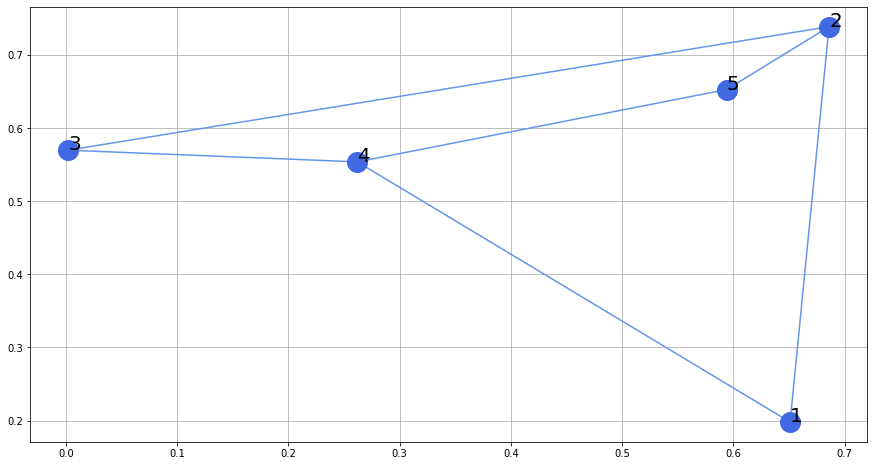

In [ ]:
vert_num, edges, edges_num = read_graph('graf_planarny1.txt')

fitness_function = fitness_func
ga_instance = pygad.GA(num_generations = 500,
                       num_parents_mating = 2,
                       sol_per_pop = 20, 
                       num_genes = vert_num*10*2,
                       parent_selection_type = "sss",
                       crossover_probability = 0.6,
                       crossover_type = "single_point",
                       mutation_probability = 0.2,
                       mutation_type = "random",
                       keep_parents = 1,
                       mutation_percent_genes = 10,
                       fitness_func=fitness_function,
                       gene_space=[0, 1])

ga_instance.run()
solution, solution_fitness, solution_idx = ga_instance.best_solution()

print("Solution fitness: ", solution_fitness)

plot_graph(solution,edges_num,edges,vert_num)


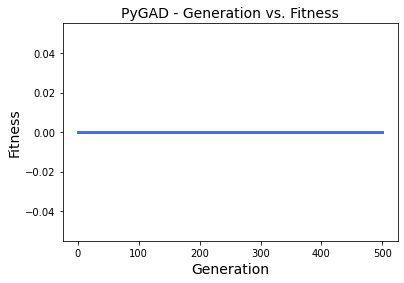

In [ ]:
ga_instance.plot_fitness()

plt.show()

###Graf 2 

Edges:  [(1, 4), (1, 2), (1, 5), (1, 3), (5, 2), (3, 2), (5, 3)]
Number of vertices:  5
Solution fitness:  0


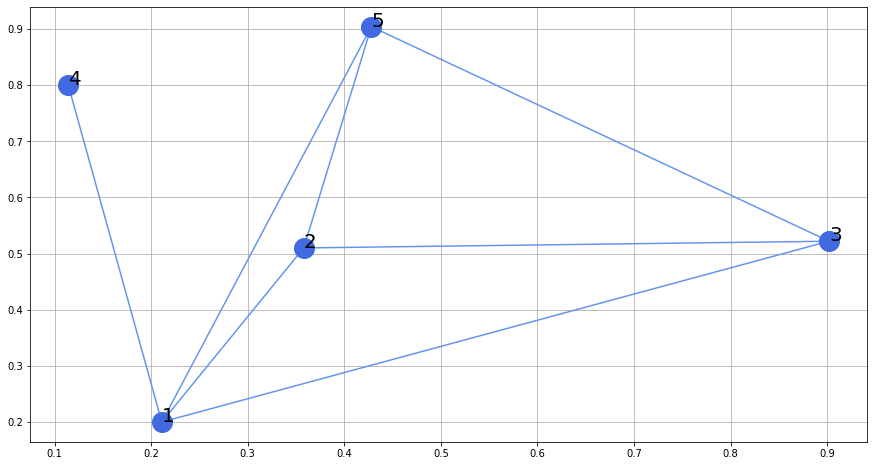

In [ ]:
vert_num, edges, edges_num = read_graph('graf_planarny2.txt')

fitness_function = fitness_func
ga_instance = pygad.GA(num_generations = 500,
                       num_parents_mating = 2,
                       sol_per_pop = 20, 
                       num_genes = vert_num*10*2,
                       parent_selection_type = "sss", 
                       crossover_probability = 0.6,
                       crossover_type = "single_point",
                       mutation_probability = 0.2,
                       mutation_type = "random",
                       keep_parents = 1,
                       mutation_percent_genes = 10,
                       fitness_func=fitness_function,
                       gene_space=[0, 1])

ga_instance.run()
solution, solution_fitness, solution_idx = ga_instance.best_solution()

print("Solution fitness: ", solution_fitness)

plot_graph(solution,edges_num,edges,vert_num)

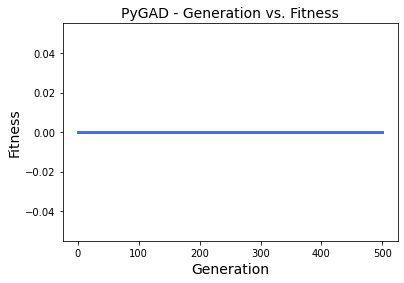

In [ ]:
ga_instance.plot_fitness()

plt.show()

Algorytm genetyczny zwrócił fitness=0 dla obu grafów. Oznacza to, że otrzymane modele nie mają przecinająch się krawędzi, czyli tak jak oczekiwano.

###Graf 3

Ten graf ma 10 wierzchołków z których 5 jest połączonych z jak największą ilością pozostałch wierzchołków, a pozostałe 5 maksymalnie z 1,2 albo 3 innymi wierzchołkami.

Edges:  [(1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (2, 7), (2, 10), (3, 4), (3, 5), (3, 6), (3, 7), (3, 9), (4, 9), (5, 7), (5, 9), (7, 9)]
Number of vertices:  10
Solution fitness:  -2


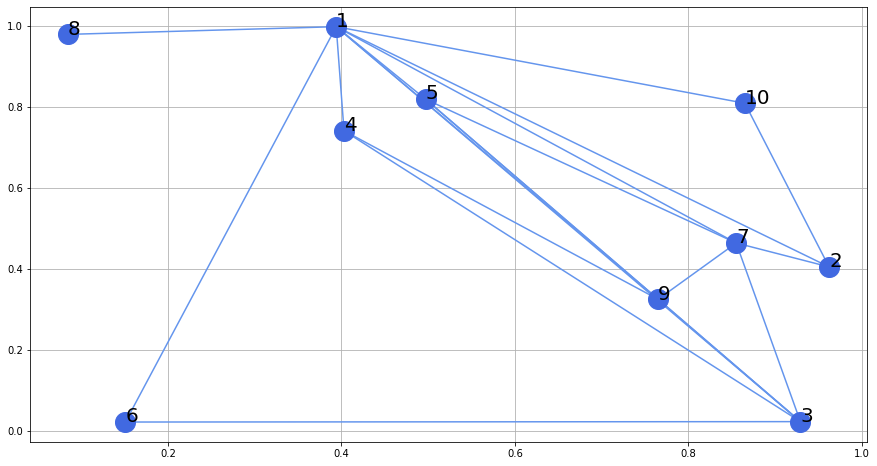

In [ ]:
vert_num, edges, edges_num = read_graph('graf_10w.txt')

fitness_function = fitness_func
ga_instance = pygad.GA(num_generations = 500,
                       num_parents_mating = 2,
                       sol_per_pop = 20, 
                       num_genes = vert_num*10*2,
                       parent_selection_type = "sss", 
                       crossover_probability = 0.6,
                       crossover_type = "single_point",
                       mutation_probability = 0.2,
                       mutation_type = "random",
                       keep_parents = 1,
                       mutation_percent_genes = 10,
                       fitness_func=fitness_function,
                       gene_space=[0, 1])

ga_instance.run()
solution, solution_fitness, solution_idx = ga_instance.best_solution()

print("Solution fitness: ", solution_fitness)

plot_graph(solution,edges_num,edges,vert_num)

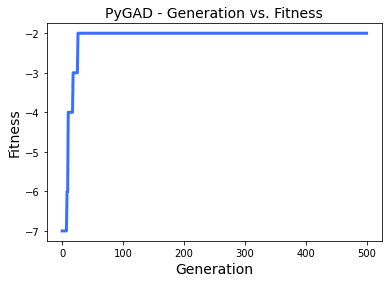

In [ ]:
ga_instance.plot_fitness()

plt.show()

Osiągnełyśmy wartość funkcji fitness=-2, czyli graf ma tylko 2 przecinające się krawędzie. 

Jednak okazuje się, że algorytm może sobie jeszcze lepiej poradzić z tym grafem, kiedy zmniejszymy prawdopodobieństwo mutacj z wartości 0.2 do 0.05.

Solution fitness:  -1


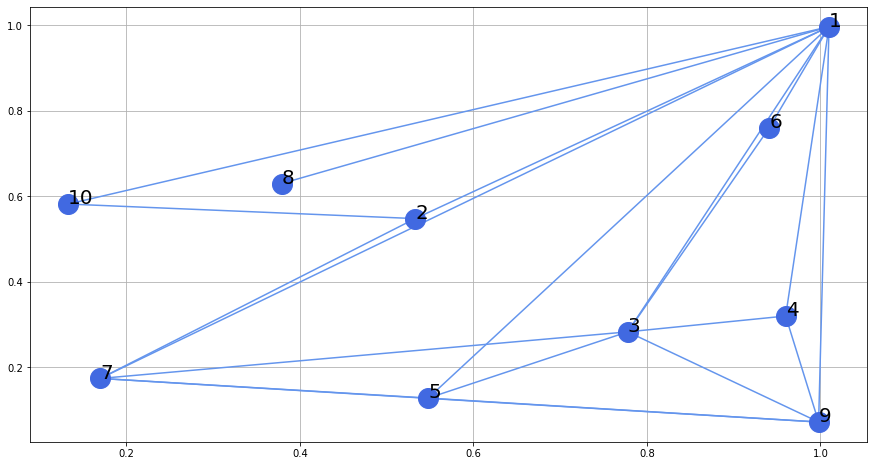

In [ ]:
fitness_function = fitness_func
ga_instance = pygad.GA(num_generations = 500,
                       num_parents_mating = 2,
                       sol_per_pop = 20, 
                       num_genes = vert_num*10*2,
                       parent_selection_type = "sss",
                       crossover_probability = 0.6,
                       crossover_type = "single_point",
                       mutation_probability = 0.05,
                       mutation_type = "random",
                       keep_parents = 1,
                       mutation_percent_genes = 10,
                       fitness_func=fitness_function,
                       gene_space=[0, 1])

ga_instance.run()
solution, solution_fitness, solution_idx = ga_instance.best_solution()

print("Solution fitness: ", solution_fitness)

plot_graph(solution,edges_num,edges,vert_num)

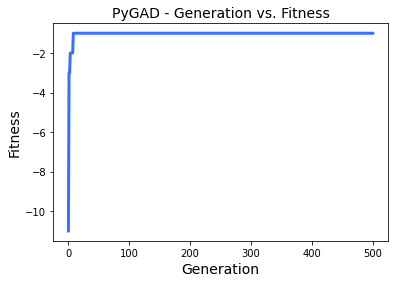

In [ ]:
ga_instance.plot_fitness()

plt.show()

Dla tego przykładu najlepszy wynik jaki otrzymałyśmy to 1 przecięcie.

###Graf 4

Ostatni graf jest najbardziej skomplikowany i ma 50 wierzchołków.

Edges:  [(1, 2), (1, 3), (2, 3), (4, 8), (8, 6), (6, 7), (7, 5), (5, 2), (2, 6), (8, 3), (11, 8), (9, 3), (10, 8), (12, 2), (13, 12), (14, 5), (14, 12), (12, 8), (5, 8), (7, 3), (16, 11), (15, 16), (17, 15), (18, 4), (19, 11), (20, 4), (21, 10), (22, 21), (22, 4), (23, 21), (24, 22), (24, 4), (22, 8), (21, 5), (18, 14), (4, 14), (25, 7), (26, 16), (27, 11), (15, 7), (17, 11), (28, 27), (29, 28), (28, 15), (29, 7), (30, 19), (31, 19), (31, 10), (10, 11), (32, 17), (33, 8), (34, 11), (35, 29), (36, 28), (39, 35), (38, 35), (39, 15), (9, 11), (1, 16), (13, 19), (34, 19), (30, 31), (20, 31), (34, 32), (37, 2), (40, 1), (41, 40), (42, 25), (43, 40), (44, 37), (45, 1), (46, 37), (47, 14), (48, 2), (49, 14), (50, 48)]
Number of vertices:  50
Solution fitness:  -145


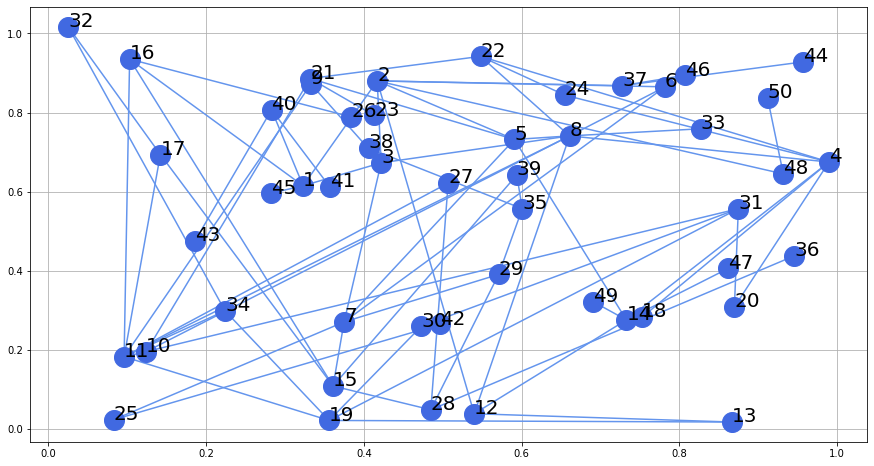

In [ ]:
vert_num, edges, edges_num = read_graph('50w.txt')

fitness_function = fitness_func
ga_instance = pygad.GA(num_generations = 500,
                       num_parents_mating = 2,
                       sol_per_pop = 20, 
                       num_genes = vert_num*10*2,
                       parent_selection_type = "sss", 
                       crossover_probability = 0.6,
                       crossover_type = "single_point",
                       mutation_probability = 0.05,
                       mutation_type = "random",
                       keep_parents = 1,
                       mutation_percent_genes = 10,
                       fitness_func=fitness_function,
                       gene_space=[0, 1])

ga_instance.run()
solution, solution_fitness, solution_idx = ga_instance.best_solution()

print("Solution fitness: ", solution_fitness)

plot_graph(solution,edges_num,edges,vert_num)

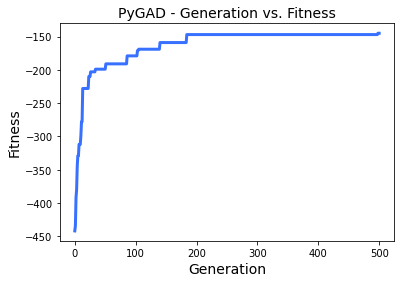

In [ ]:
ga_instance.plot_fitness()

plt.show()

Dla większej ilości wierzchołków algorytm porzebuje więcej generacji aby ustabilizować wynik oraz daje gorsze rezultaty, otrzymujemy graf, który ma bardzo dużo przecięć.

## Część 2

Poniżej przedstawiono 4 eksperymenty, które polegają na zmianie pojedynczych parametrów algorytmu. Do obliczeń używamy grafu, który ma 11 wierchołków i nie da się go narysować bez przecinających się krawędzi. Optymalne rozłożenie grafu dla tego przykładu wymaga 18 przecięć (graf pochodzący z podrozdziału "Problem cegielni Turana").

Dla każdego modelu algorytmu obliczono średni wynik liczby przecięć dla najlepszych osobników, aby porównać eksperymenty.

In [ ]:
def plot_resaults(solutions_list):
  plt.figure(figsize=(12,6))
  plt.plot(solutions_list)
  plt.axhline(y = np.average(solutions_list), color='black', label='average = '+str(np.average(solutions_list)))
  plt.xlabel("iteration number")
  plt.ylabel("solution - fitness")
  plt.legend()

In [ ]:
def stats(data):
  n = len(data)
  # Mean of the data
  mean = sum(data) / n
  # Square deviations
  deviations = [(x - mean) ** 2 for x in data]
  # Variance
  variance = sum(deviations) / n
  return mean, deviations, variance


Model podstawowy - uśrednione wyniki

In [ ]:
vert_num, edges, edges_num = read_graph('data2.txt')

fitness_function = fitness_func
ga_instance = pygad.GA(num_generations = 500,
                      num_parents_mating = 2,
                      sol_per_pop = 20, 
                      num_genes = vert_num*10*2,
                      parent_selection_type = "sss", 
                      crossover_probability = 0.6,
                      crossover_type = "single_point",
                      mutation_probability = 0.2,
                      mutation_type = "random",
                      keep_parents = 1,
                      mutation_percent_genes = 10,
                      fitness_func=fitness_function,
                      gene_space=[0, 1])

ga_instance.run()
solution, solution_fitness, solution_idx = ga_instance.best_solution()

print("Solution fitness: ", solution_fitness)


Edges:  [(1, 8), (1, 9), (1, 10), (1, 11), (2, 8), (2, 9), (2, 10), (2, 11), (3, 8), (3, 9), (3, 10), (3, 11), (4, 8), (4, 9), (4, 10), (4, 11), (5, 8), (5, 9), (5, 10), (5, 11), (6, 8), (6, 9), (6, 10), (6, 11), (7, 8), (7, 9), (7, 10), (7, 11)]
Number of vertices:  11
Solution fitness:  -22


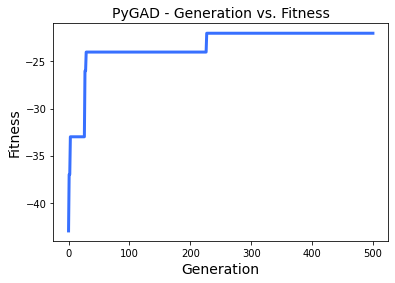

In [ ]:
ga_instance.plot_fitness()

plt.show()

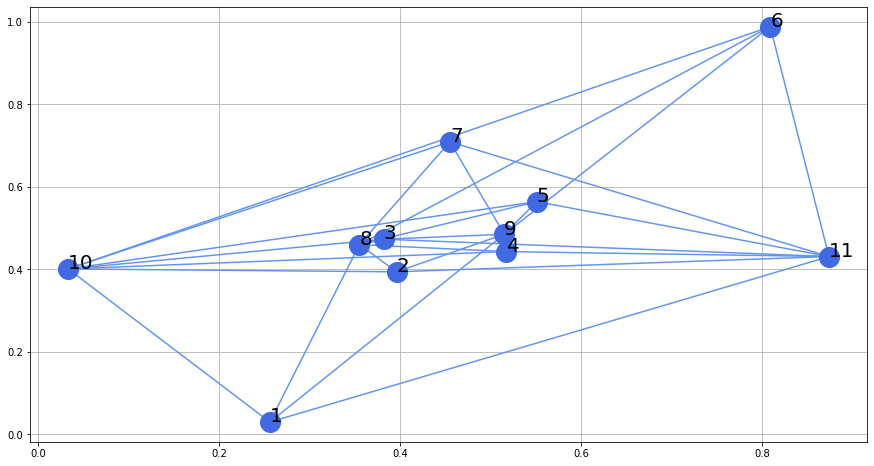

In [ ]:
plot_graph(solution,edges_num,edges,vert_num)

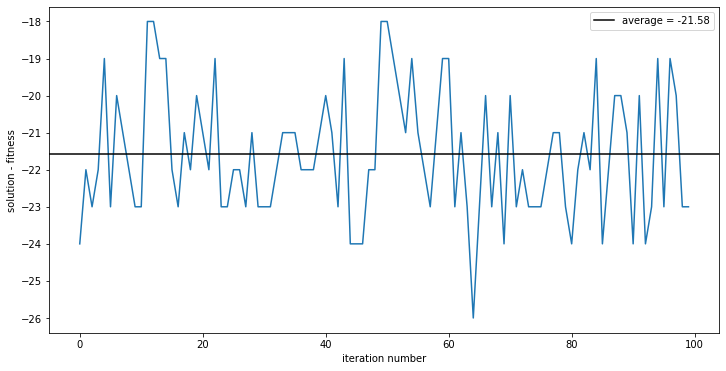

In [ ]:
resaults_basic = [-24, -22, -23, -22, -19, -23, -20, -21, -22, -23, -23, -18, -18, -19, -19, -22, -23, -21, -22, -20, -21, -22, -19, -23, -23, -22, -22, -23, -21, -23, -23, -23, -22, -21, -21, -21, -22, -22, -22, -21, -20, -21, -23, -19, -24, -24, -24, -22, -22, -18, -18, -19, -20, -21, -19, -21, -22, -23, -21, -19, -19, -23, -21, -23, -26, -23, -20, -23, -21, -24, -20, -23, -22, -23, -23, -23, -22, -21, -21, -23, -24, -22, -21, -22, -19, -24, -22, -20, -20, -21, -24, -20, -24, -23, -19, -23, -19, -20, -23, -23]
plot_resaults(resaults_basic)


In [ ]:
mean, deviations, variance = stats(resaults_basic)
print("Mean: ", mean)
print("Variance: ", variance)

Mean:  -21.58
Variance:  2.9036000000000013


czas wykonania: 98 min

### Eksperyment 1
Zmiana krzyżowania jednopunktowego na dwupunktowe (crossover_type).

In [ ]:

fitness_function = fitness_func
ga_instance = pygad.GA(num_generations = 500,
                       num_parents_mating = 2,
                       sol_per_pop = 20, 
                       num_genes = vert_num*10*2,
                       parent_selection_type = "sss", 
                       crossover_probability = 0.6,
                       crossover_type = "two_points",
                       mutation_probability = 0.2,
                       mutation_type = "random",
                       keep_parents = 1,
                       mutation_percent_genes = 10,
                       fitness_func=fitness_function,
                       gene_space=[0, 1])

ga_instance.run()
solution, solution_fitness, solution_idx = ga_instance.best_solution()

print("Solution fitness: ", solution_fitness)

Solution fitness:  -22


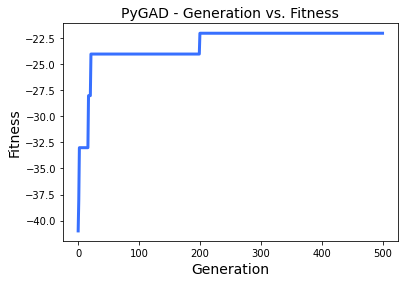

In [ ]:
ga_instance.plot_fitness()

plt.show()

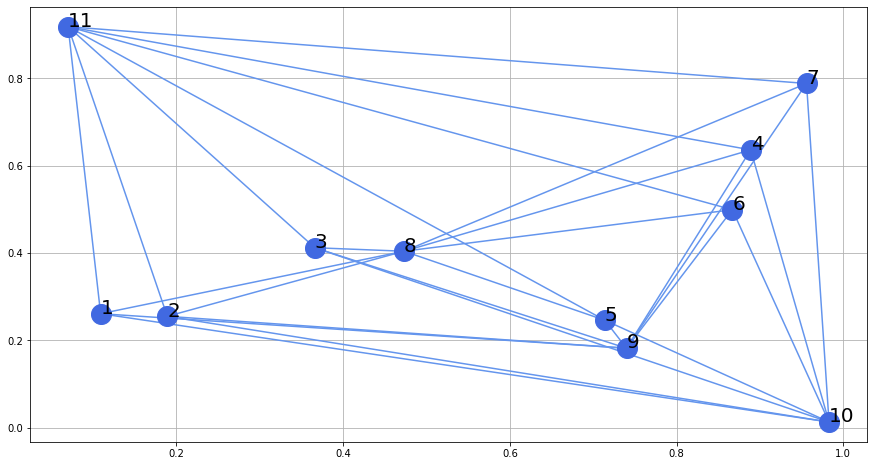

In [ ]:
plot_graph(solution,edges_num,edges,vert_num)

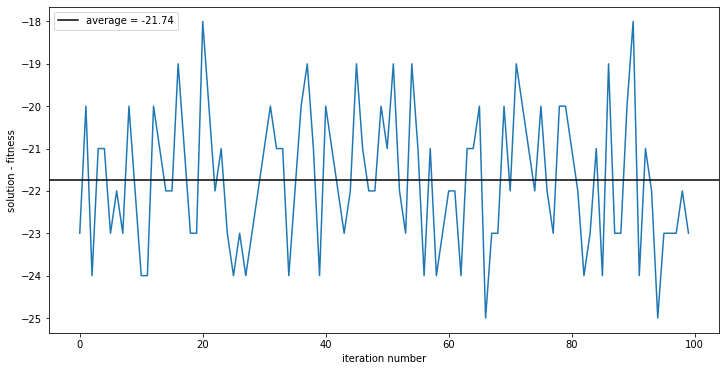

In [ ]:
resault_two_points_crossover = [-23, -20, -24, -21, -21, -23, -22, -23, -20, -22, -24, -24, -20, -21, -22, -22, -19, -21, -23, -23, -18, -20, -22, -21, -23, -24, -23, -24, -23, -22, -21, -20, -21, -21, -24, -22, -20, -19, -21, -24, -20, -21, -22, -23, -22, -19, -21, -22, -22, -20, -21, -19, -22, -23, -19, -21, -24, -21, -24, -23, -22, -22, -24, -21, -21, -20, -25, -23, -23, -20, -22, -19, -20, -21, -22, -20, -22, -23, -20, -20, -21, -22, -24, -23, -21, -24, -19, -23, -23, -20, -18, -24, -21, -22, -25, -23, -23, -23, -22, -23]
plot_resaults(resault_two_points_crossover)

In [ ]:
mean, deviations, variance = stats(resault_two_points_crossover)
print("Mean: ", mean)
print("Variance: ", variance)

Mean:  -21.74
Variance:  2.592400000000002


#### Wnioski
Po zmianie krzyżowania z jednopunktowego na krzyżowanie dwupunktowe otrzymujemy bardzo zbliżone do siebie uśrednione wyniki. Dla krzyżowania jednopunktowego: -21.58, dla krzyżowania dwupunktowego: -21.74.

czas wykonania: 110 min

### Eksperyment 2
Zmiana prawdopodobieństwa mutacji z 0.2 na 0.5 (mutation_probability).

In [ ]:
fitness_function = fitness_func 
ga_instance = pygad.GA(num_generations = 500,
                       num_parents_mating = 2,
                       sol_per_pop = 20, 
                       num_genes = vert_num*10*2,
                       parent_selection_type = "sss",
                       crossover_probability = 0.6,
                       crossover_type = "single_point",
                       mutation_probability = 0.5,
                       mutation_type = "random",
                       keep_parents = 1,
                       mutation_percent_genes = 10,
                       fitness_func=fitness_function,
                       gene_space=[0, 1])

ga_instance.run()
solution, solution_fitness, solution_idx = ga_instance.best_solution()

print("Solution fitness: ", solution_fitness)

Solution fitness:  -25


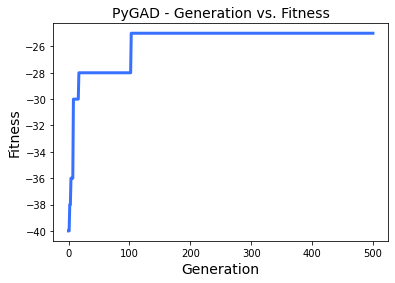

In [ ]:
ga_instance.plot_fitness()

plt.show()

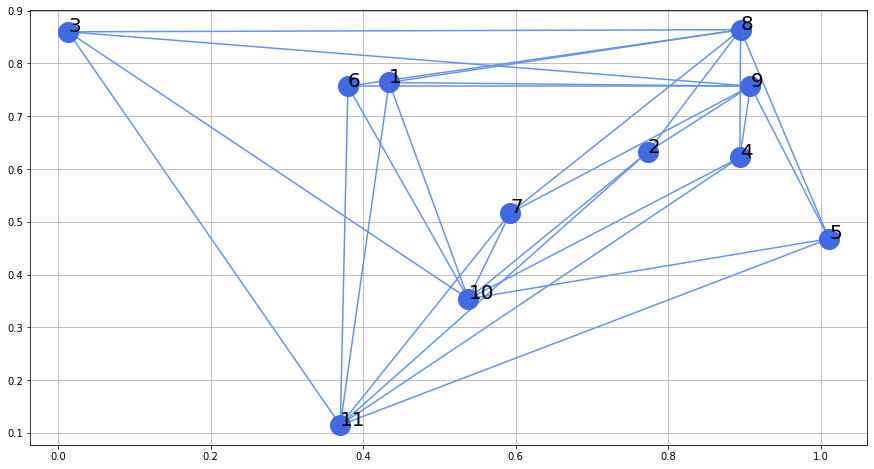

In [ ]:
plot_graph(solution,edges_num,edges,vert_num)

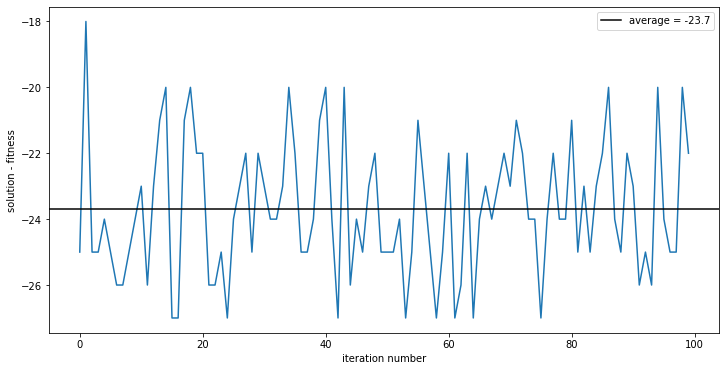

In [ ]:
resault_mutation_probability = [-25, -18, -25, -25, -24, -25, -26, -26, -25, -24, -23, -26, -23, -21, -20, -27, -27, -21, -20, -22, -22, -26, -26, -25, -27, -24, -23, -22, -25, -22, -23, -24, -24, -23, -20, -22, -25, -25, -24, -21, -20, -24, -27, -20, -26, -24, -25, -23, -22, -25, -25, -25, -24, -27, -25, -21, -23, -25, -27, -25, -22, -27, -26, -22, -27, -24, -23, -24, -23, -22, -23, -21, -22, -24, -24, -27, -24, -22, -24, -24, -21, -25, -23, -25, -23, -22, -20, -24, -25, -22, -23, -26, -25, -26, -20, -24, -25, -25, -20, -22]
plot_resaults(resault_mutation_probability)

In [ ]:
mean, deviations, variance = stats(resault_mutation_probability)
print("Mean: ", mean)
print("Variance: ", variance)

Mean:  -23.7
Variance:  4.169999999999998


####Wnioski
Po zwiększeniu prawdopodobieństwa mutacji z 0.2 do 0.5 otrzymujemy gorszy średni wynik. Przy prawdopodobieństwie mutacji wynoszącym 0.2 wynosił on -21.58, natomiast przy prawdopododobieństwie mutacji równym 0.5 wynosi -23.7.

czas wykonania: 109 min

### Eksperyment 3
Zmiana sposobu selekcji z steady state selection na koło ruletki (parent_selection_type). 

In [ ]:
solution_fitness_arr = []

fitness_function = fitness_func
ga_instance = pygad.GA(num_generations = 500,
                       num_parents_mating = 2,
                       sol_per_pop = 20, 
                       num_genes = vert_num*10*2,
                       parent_selection_type = "rws", 
                       crossover_probability = 0.6,
                       crossover_type = "single_point",
                       mutation_probability = 0.2,
                       mutation_type = "random",
                       keep_parents = 1,
                       mutation_percent_genes = 10,
                       fitness_func=fitness_function,
                       gene_space=[0, 1])

ga_instance.run()
solution, solution_fitness, solution_idx = ga_instance.best_solution()

print("Solution fitness: ", solution_fitness)

Solution fitness:  -24


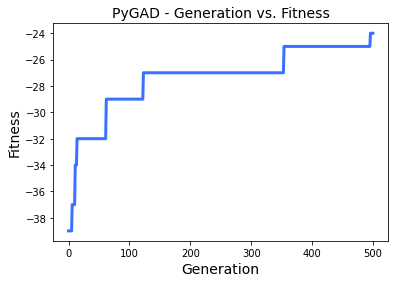

In [ ]:
ga_instance.plot_fitness()

plt.show()

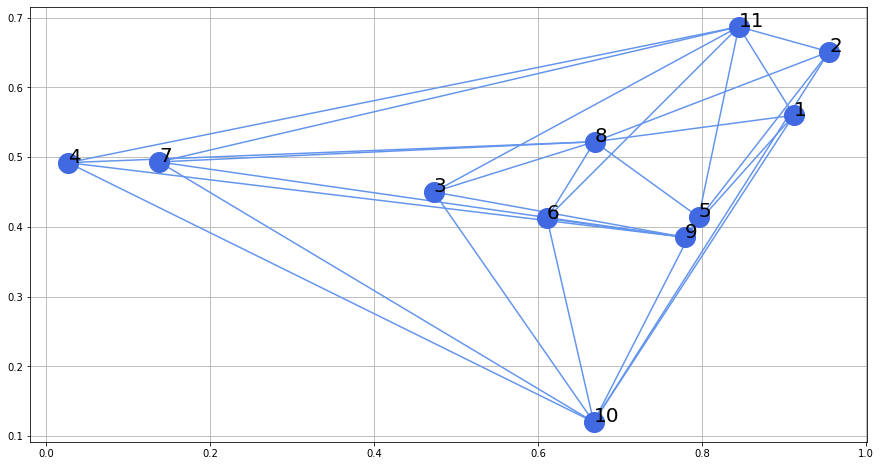

In [ ]:
plot_graph(solution,edges_num,edges,vert_num)

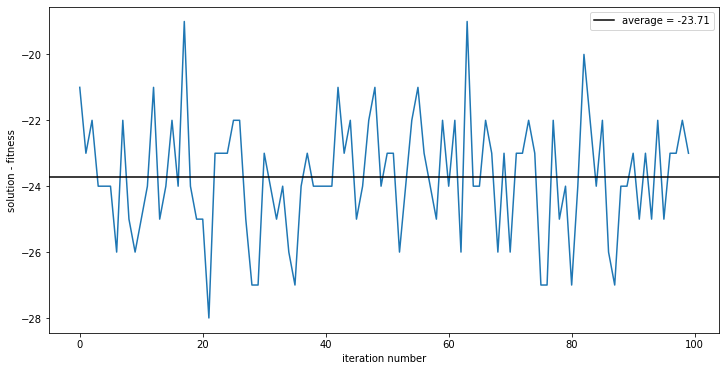

In [ ]:
resault_rws = [-21, -23, -22, -24, -24, -24, -26, -22, -25, -26, -25, -24, -21, -25, -24, -22, -24, -19, -24, -25, -25, -28, -23, -23, -23, -22, -22, -25, -27, -27, -23, -24, -25, -24, -26, -27, -24, -23, -24, -24, -24, -24, -21, -23, -22, -25, -24, -22, -21, -24, -23, -23, -26, -24, -22, -21, -23, -24, -25, -22, -24, -22, -26, -19, -24, -24, -22, -23, -26, -23, -26, -23, -23, -22, -23, -27, -27, -22, -25, -24, -27, -24, -20, -22, -24, -22, -26, -27, -24, -24, -23, -25, -23, -25, -22, -25, -23, -23, -22, -23]
plot_resaults(resault_rws)

In [ ]:
mean, deviations, variance = stats(resault_rws)
print("Mean: ", mean)
print("Variance: ", variance)

Mean:  -23.71
Variance:  3.1459


#### Wnioski
Po zmianie metody selekcji z Steady State Selection na Ruletkę otrzymujemy gorszy uśredniony wynik. Przy Steady State Selection wynosił on -21.58, natomiast przy Ruletce wynosi -23.71.

czas wykonania: 108 min

### Eksperyment 4 
Zmniejszenie prawdopodobieństwa mutacji z 0.2 do 0.05 (mutation_probability). Wartość 0.05 jest odwrotnością ilości osobników (1/20)

In [ ]:
fitness_function = fitness_func
ga_instance = pygad.GA(num_generations = 500,
                      num_parents_mating = 2,
                      sol_per_pop = 20, 
                      num_genes = vert_num*10*2,
                      parent_selection_type = "sss", 
                      crossover_probability = 0.6,
                      crossover_type = "single_point",
                      mutation_probability = 0.05,
                      mutation_type = "random",
                      keep_parents = 1,
                      mutation_percent_genes = 10,
                      fitness_func=fitness_function,
                      gene_space=[0, 1])

ga_instance.run()
solution, solution_fitness, solution_idx = ga_instance.best_solution()


print("Solution fitness: ", solution_fitness)

Solution fitness:  -18


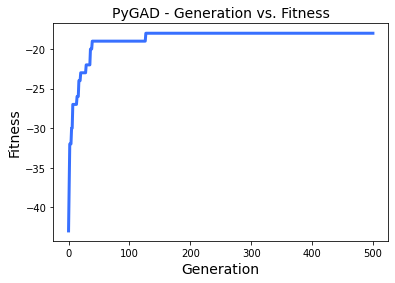

In [ ]:
ga_instance.plot_fitness()

plt.show()

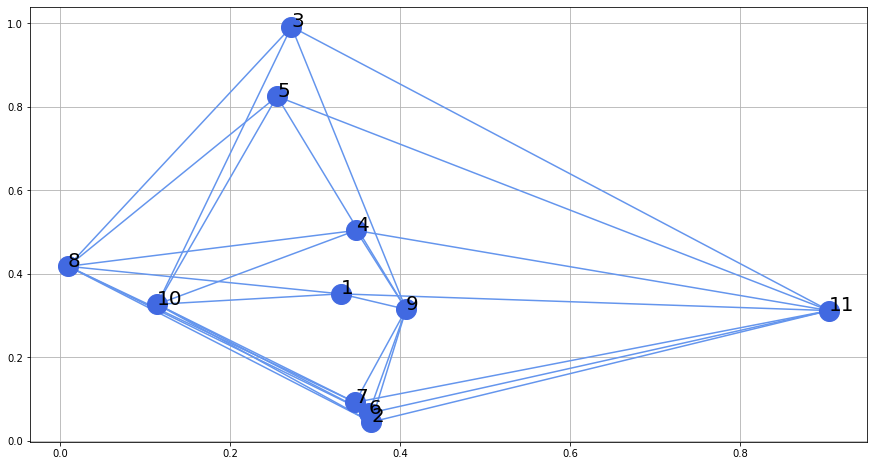

In [ ]:
plot_graph(solution,edges_num,edges,vert_num)

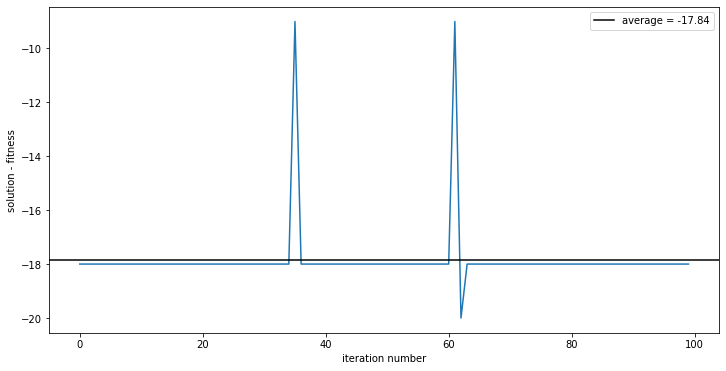

In [ ]:
reasult_small_mutation = [-18, -18, -18, -18, -18, -18, -18, -18, -18, -18, -18, -18, -18, -18, -18, -18, -18, -18, -18, -18, -18, -18, -18, -18, -18, -18, -18, -18, -18, -18, -18, -18, -18, -18, -18, -9, -18, -18, -18, -18, -18, -18, -18, -18, -18, -18, -18, -18, -18, -18, -18, -18, -18, -18, -18, -18, -18, -18, -18, -18, -18, -9, -20, -18, -18, -18, -18, -18, -18, -18, -18, -18, -18, -18, -18, -18, -18, -18, -18, -18, -18, -18, -18, -18, -18, -18, -18, -18, -18, -18, -18, -18, -18, -18, -18, -18, -18, -18, -18, -18]
plot_resaults(reasult_small_mutation)

In [ ]:
mean, deviations, variance = stats(reasult_small_mutation)
print("Mean: ", mean)
print("Variance: ", variance)

Mean:  -17.84
Variance:  1.6343999999999985


#### Wnioski
Zmniejszenie prawdopodobieństwa mutacji doprowadziło do otrzymania pożądanego wyniku 18 przecięć dla naszego grafu.

Podczas eksperymentów kilka razy otrzymaliśmy niższą wartość - co nie powinno być możliwe, ponieważ 18 to optymalny wynik. Inne wyniki jakie otrzymywałyśmy w tym przykładzie to 16 lub 9 przecięć. Działo się tak ponieważ algorytm nakładał na siebie 2 różne wierzchołki (według naszej imlementacji funkcji która sprawdza czy krawędzie się przecinają, nie uznajemy przecięć jeśli przecięcie wystąpiło w wierzchołku, ani nie obsługujemy możliwośći całkowitego nałożenia się na siebie krawędzi, jest to uznawane za brak przecięcia).

Poniżej znajduje się wizualizacja grafu z 16 przecięciami. Widać, że wierzchołek 7 i 4 się nałożyły.

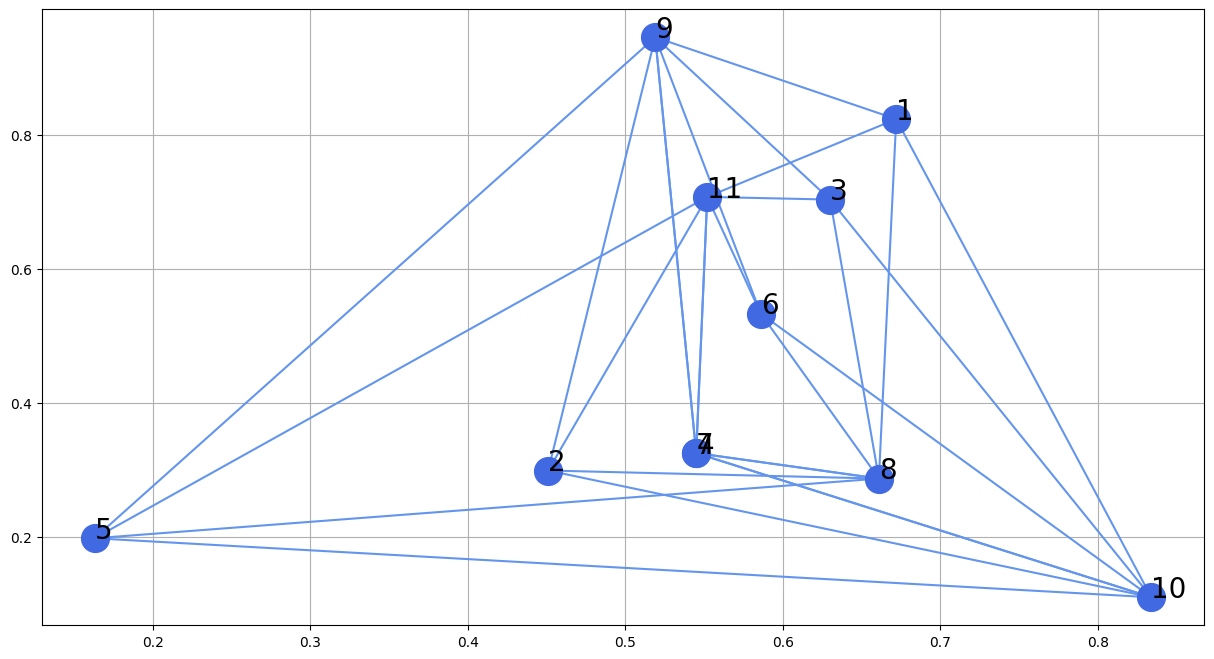

Poniżej znajduje się wizualizacja dla 9 przecięć, tutaj nałożyły się wierzchołki 8 i 11

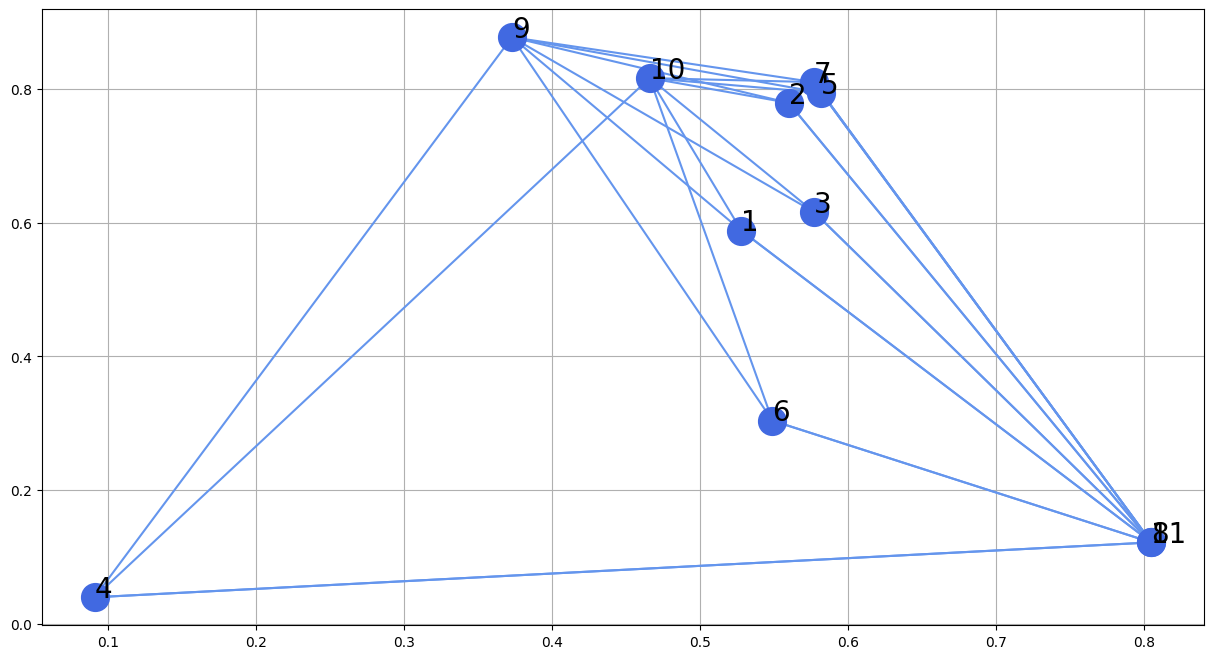

###Podsumowanie

Najlepsze wyniki, czyli najmniejszą możliwą liczbę przecięć krawędzi otrzymałyśmy kiedy zmniejszałyśmy prawdopodobieństwo mutacji.

Może być to wywołane tym, że wysokie prawdopodobieństwo mutacji sprzyja powstawaniu osobników, które w skrajnych przypadkach mogą się znacznie różnić od wcześniejszych, a te zmiany niekoniecznie muszą przebiegać w pożądanym kierunku. Ostatecznie taka mutacja może drastycznie zmieniać położenie wierzchołka i utrudniać osiągnięcie minimalnej liczby przecieć krawędzi w zadanej liczbie generacji.


W pozostałych przypadkach, gdzie zmieniałyśmy typ operacji crossover czy metode selekcji, zmiany w średniej liczbie przecieć krawędzi nie były bardzo znaczące. 